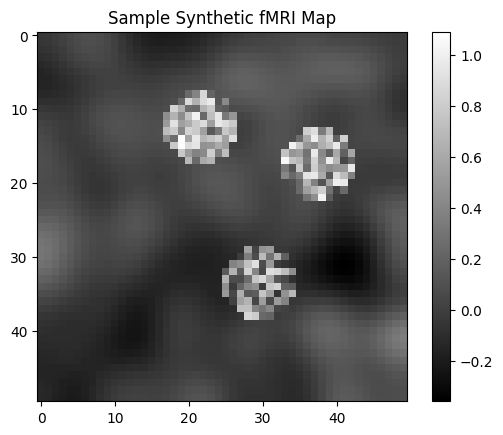

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.ndimage import gaussian_filter

def generate_blob(grid_size, blob_radius, jitter):
    """Generate a single blob with random jitter."""
    center = np.random.randint(blob_radius, grid_size - blob_radius, size=2) + jitter
    y, x = np.ogrid[-center[0]:grid_size-center[0], -center[1]:grid_size-center[1]]
    mask = x**2 + y**2 <= blob_radius**2
    blob = np.zeros((grid_size, grid_size))
    blob[mask] = 1
    return blob

def generate_map(grid_size, max_blobs, jitter):
    """Generate a spatial map with blobs and jitter."""
    map = np.zeros((grid_size, grid_size))
    num_blobs = binom.rvs(n=3, p=0.5, size=1)[0]  # Binomial distribution for number of blobs
    blob_radii = np.random.randint(5, 15, size=num_blobs)  # Random radius for each blob

    for _ in range(max_blobs):
        if num_blobs > 0:
            radius = np.random.choice(blob_radii)
            blob = generate_blob(grid_size, radius, jitter)
            map += blob  # Add blob to the map

    return map

def generate_synthetic_fmri_data(subjects, maps_per_subject, time_points, grid_size):
    """Generate synthetic fMRI data for multiple subjects."""
    data = np.zeros((subjects, maps_per_subject, grid_size, grid_size, time_points))

    for subject in range(subjects):
        jitter = np.random.normal(0, 1, 2)  # Gaussian-distributed jitter
        for map_index in range(maps_per_subject):
            spatial_map = generate_map(grid_size, max_blobs=3, jitter=jitter)
            for time_point in range(time_points):
                time_series = np.random.rand(grid_size, grid_size)
                noise = gaussian_filter(np.random.randn(grid_size, grid_size), sigma=3)
                data[subject, map_index, :, :, time_point] = spatial_map * time_series + noise

    return data

# Parameters
subjects = 12
maps_per_subject = 5
time_points = 150
grid_size = 50

# Generate synthetic fMRI data
synthetic_data = generate_synthetic_fmri_data(subjects, maps_per_subject, time_points, grid_size)

# Visualize one of the generated maps
plt.imshow(synthetic_data[0, 3, :, :, 0], cmap='gray')
plt.title("Sample Synthetic fMRI Map")
plt.colorbar()
plt.show()


In [54]:
import statistics

def prox(V):
    return V

def laplacian_old(v_grid):
    """
    returns Lv where L is the laplacian operator
    v is a np.array of size p1*p2
    """
    v_grid_padded = np.pad(v_grid, ((1, 1), (1, 1)), mode='edge')
    p1, p2 = v_grid.shape
    Lv = np.zeros((p1+2, p2+2)) #add padding for the extremities
    
    for i in range(p1):
        for j in range(p2):
            i0 = i + 1
            j0 = j + 1
            Lv[i0, j0] = v_grid_padded[i0+1,j0] + v_grid_padded[i0,j0+1] + v_grid_padded[i0-1,j0] + v_grid_padded[i0,j0-1] - 4*v_grid_padded[i0,j0]
    return Lv[1:-1, 1:-1]


def omega(V):
    """
    returns omega(v) where v is a np array of size p1*p2
    """
    norm1_v = np.sum(np.abs(V))

    return norm1_v 

def compute_energy(Ys,Us,Vs,V,mu,lambda_r, regularization_fun = None):
    if regularization_fun is None :
        regularization_fun= lambda x : omega(x)
        
    S = len(Us)  # Number of subjects
    energy = 0
    for s in range(S):
        term1 = np.linalg.norm(Ys[s] - Us[s] @ Vs[s].T, 'fro')**2
        term2 = mu * np.linalg.norm(Vs[s] - V, 'fro')**2
        energy += 0.5 * (term1 + term2)
    
    regularizer = regularization_fun(V) 
    print(regularizer)

    energy += lambda_r * regularizer
    print(energy)
    return energy

def update_vs(V, us ,ys , mu):
    # Mettre à jour Vs en utilisant la régression ridge
    id = np.identity(us.shape[1])
    vs = V + (ys-us@vs.T)@ us@ np.linalg.inv(us.T@us + mu * id )
    return vs

def update_us(ys, vs, u_l):
    u_l_new = u_l + np.linalg.norm(u_l, 2)**-2 * (ys - u_l @ vs.T @ vs)
    u_l_new = u_l_new / max(np.linalg.norm(u_l_new, 2), 1)
    return u_l_new
    

def algorithm(Ys,V, k, mu, lambda_r, max_iter=1000, tolerance=1e-4):
    n,p = Ys.shape[1:] # n number of time points, p number of voxels 
    S = len(Ys)     # S number of subjects
    
    # group level spatial maps
    Vs = [np.random.rand(p, k) for _ in range(S)]  # subject specific spatial maps
    Us = [np.random.rand(n, k) for _ in range(S)]  # time series
    E_old = float('inf')
    E_new = compute_energy(Ys,Us,Vs,V,mu,lambda_r)
    print(E_new)
    print(E_old)
    print(E_new)
    i = 0
    while np.abs(E_new - E_old) > tolerance * E_old and i < max_iter:
        E_old = E_new
        
        # Update each U^s
        for s in range(S):
            for l in range(k):
                Us[s][:, l] = update_us(Ys[s], Vs[s], Us[s][:, l])
                
            Vs = update_vs(V,Us[s],Ys[s] , mu)
            
        Vs_mean = statistics.mean(Vs)
        # Apply the proximal operator to the mean of every subject spatial maps
        V = prox(Vs_mean, lambda_r)
        
        # Compute the energy
        E_new = compute_energy(Ys,Us,Vs,V,mu,lambda_r)
        i += 1
    
    return V,Vs,Us

In [55]:
import numpy 
Ys = numpy.load('synthetic_data.npy')
Ys.shape

Ys = Ys.reshape(4, 150, -1)
Ys.shape

(4, 150, 2500)

In [58]:
mu = 0.1
k = 5
p = Ys.shape[2]
V = np.random.rand(p, k)
V.shape

(2500, 5)

In [60]:
V,Vs,Us= algorithm(Ys,V, k, mu, 0.1)


6271.52657809842
16460976.367794337
16460976.367794337
inf
16460976.367794337
[[0.22140024 0.68205167 0.33019962 0.39727    0.83054225]
 [0.6671349  0.00628934 0.17751493 0.65411298 0.55538741]
 [0.57977493 0.57638045 0.87085742 0.3232843  0.53375402]
 ...
 [0.43903466 0.521061   0.05524308 0.94143801 0.71686136]
 [0.14663302 0.7070323  0.01389501 0.03114486 0.4741845 ]
 [0.63969705 0.8390472  0.37371306 0.74014573 0.82533669]] [array([[0.08702503, 0.87664018, 0.94067563, 0.19486403, 0.38753969],
       [0.39705641, 0.3201926 , 0.1267615 , 0.25299097, 0.5055168 ],
       [0.66642677, 0.70756086, 0.74243194, 0.0610858 , 0.73777387],
       ...,
       [0.22939246, 0.5946729 , 0.02693693, 0.83740986, 0.93199966],
       [0.42631941, 0.32873234, 0.06907951, 0.48547948, 0.07034499],
       [0.00832757, 0.46068907, 0.64952886, 0.12351894, 0.23429847]]), array([[0.54921261, 0.65045314, 0.14716106, 0.29631007, 0.18959397],
       [0.96518646, 0.18968309, 0.3666381 , 0.86922015, 0.33337061],
 